In [1]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import numpy as np
import sklearn
import string
import re
import nltk
import tensorflow as tf
from collections import Counter
from tensorflow import keras
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.utils import class_weight
from keras.utils import pad_sequences
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import accuracy_score
from datetime import datetime
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from google.colab import files,drive
from wordcloud import WordCloud, STOPWORDS
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import GridSearchCV,StratifiedKFold
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
print("Running Panda Version:"+pd.__version__)
print("Running TensorFlow Version:"+ tf.__version__)
print("Running Keras API Version:"+ keras.__version__)
print("Running Python {0}.{1}".format(sys.version_info[:2][0],sys.version_info[:2][1]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Running Panda Version:2.2.2
Running TensorFlow Version:2.17.0
Running Keras API Version:3.4.1
Running Python 3.10


In [2]:
seed = 0
np.random.seed(seed)

In [3]:
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


# ***Exploratory Data Analysis***

In [4]:
dataset = pd.read_csv("Tweets.csv",na_values=['NA'], low_memory=False)

### Dataset shapes

In [5]:
print('Dataset structure: rows =',dataset.shape[0], ' - columns =',dataset.shape[1])

Dataset structure: rows = 14640  - columns = 15


##### Some random rows

In [6]:
dataset.sample(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
13983,569682010270101504,negative,0.6163,Late Flight,0.6163,American,NaN,zsalim03,NaN,0,@AmericanAir In car gng to DFW. Pulled over 1h...,NaN,2015-02-22 18:15:50 -0800,Texas,Central Time (US & Canada)
14484,569608307184242688,negative,0.7039,Bad Flight,0.3587,American,NaN,sa_craig,NaN,0,"@AmericanAir after all, the plane didn’t land ...",NaN,2015-02-22 13:22:57 -0800,"College Station, TX",Central Time (US & Canada)
6403,567879304593408001,negative,1.0000,Cancelled Flight,1.0000,Southwest,NaN,DanaChristos,NaN,1,@SouthwestAir can't believe how many paying cu...,NaN,2015-02-17 18:52:31 -0800,CT,Eastern Time (US & Canada)


###  Descriptive statistics for the dataset

In [7]:
print('Dataset Features types:')
dataset.dtypes

Dataset Features types:


,0
tweet_id,int64
airline_sentiment,object
airline_sentiment_confidence,float64
negativereason,object
negativereason_confidence,float64
airline,object
airline_sentiment_gold,object
name,object
negativereason_gold,object
retweet_count,int64


In [8]:
print("List of names of columns:\n")
print('-'*50)
dataset.columns.tolist()

List of names of columns:

--------------------------------------------------


['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [9]:
print('Descriptive Statistics for numeric features on Dataset')
dataset.describe(include=np.number)

Descriptive Statistics for numeric features on Dataset


,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [10]:
print('Range for numeric features on Dataset')
print('-'*40)
dataset.max(numeric_only=True) - dataset.min(numeric_only=True)

Range for numeric features on Dataset
----------------------------------------


,0
tweet_id,2.722322e+15
airline_sentiment_confidence,6.650000e-01
negativereason_confidence,1.000000e+00
retweet_count,4.400000e+01


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [12]:
print('Descriptive Statistics for categorical features on Dataset')
dataset.describe(include=object)

Descriptive Statistics for categorical features on Dataset


,airline_sentiment,negativereason,airline,airline_sentiment_gold,name,negativereason_gold,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,14640,9178,14640,40,14640,32,14640,1019,14640,9907,9820
unique,3,10,6,3,7701,13,14427,832,14247,3081,85
top,negative,Customer Service Issue,United,negative,JetBlueNews,Customer Service Issue,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9178,2910,3822,32,63,12,6,164,5,157,3744


In [13]:
print('Number of classes: ',len(dataset.airline_sentiment.unique().tolist()))

Number of classes:  3


In [14]:
print('Name of classes (y): ',dataset.airline_sentiment.unique().tolist())

Name of classes (y):  ['neutral', 'positive', 'negative']


In [15]:
print('Check for duplicates?',dataset.duplicated().any())
print('-'*70)
print('Sum of duplicated rows :',dataset.duplicated().sum())

Check for duplicates? True
----------------------------------------------------------------------
Sum of duplicated rows : 36


In [16]:
print('Check for missing values ',dataset.isnull().any().any())
print('-'*70)
print('Sum of Missing values accross columns\n',dataset.isnull().sum())
print('-'*70)
print("Sum of missing values",sum(dataset.isnull().sum()))

Check for missing values  True
----------------------------------------------------------------------
Sum of Missing values accross columns
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
----------------------------------------------------------------------
Sum of missing values 61962


In [17]:
missing_data=dataset[dataset.isnull().any(axis=1)]
missing_data.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [18]:
dataset.airline_sentiment.value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


####Data imbalance, more negative and neutral sentiment than positive.

In [19]:
list_of_airlines =dataset.airline.unique().tolist()
print('list of airlines: ',list_of_airlines)

list of airlines:  ['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American']


In [20]:
print("Time of first tweet in the dataset:",dataset.tweet_created.min())
print('-'*70)
print("Time of last tweet in the dataset:",dataset.tweet_created.max())

Time of first tweet in the dataset: 2015-02-16 23:36:05 -0800
----------------------------------------------------------------------
Time of last tweet in the dataset: 2015-02-24 11:53:37 -0800


In [21]:
print("Airlines with tweet count\n", dataset.airline.value_counts())

Airlines with tweet count
 airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64


In [22]:
print("Tweets frequencies grouped by sentiments for the airlines")
print('-'*80)
airlines_sentiments_groups = dataset.groupby("airline", group_keys=True)[['airline_sentiment']].value_counts()
airlines_sentiments_groups

Tweets frequencies grouped by sentiments for the airlines
--------------------------------------------------------------------------------


airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: count, dtype: int64

In [23]:
print("Maximum tweet confidence",dataset.airline_sentiment_confidence.max())
print('-'*80)
print("Minimum tweet confidence",dataset.airline_sentiment_confidence.min())

Maximum tweet confidence 1.0
--------------------------------------------------------------------------------
Minimum tweet confidence 0.335


In [24]:
print(dataset.airline_sentiment_confidence.quantile([0,0.25,0.50,0.75,1]))

0.00    0.3350
0.25    0.6923
0.50    1.0000
0.75    1.0000
1.00    1.0000
Name: airline_sentiment_confidence, dtype: float64


####25 percent quantile for sentiment confidence is 0.65, which means that 25 percent of the dataset values for this measure is less than 0.65.

In [25]:
dataset['negativereason'] =  dataset['negativereason'].fillna('N/A')

In [26]:
dataset[dataset['negativereason'] != 'N/A'].groupby("airline", group_keys=True)[['negativereason']].value_counts()

airline         negativereason             
American        Customer Service Issue         768
                Late Flight                    249
                Cancelled Flight               246
                Can't Tell                     198
                Lost Luggage                   149
                Flight Booking Problems        130
                Bad Flight                      87
                Flight Attendant Complaints     87
                longlines                       34
                Damaged Luggage                 12
Delta           Late Flight                    269
                Customer Service Issue         199
                Can't Tell                     186
                Bad Flight                      64
                Flight Attendant Complaints     60
                Lost Luggage                    57
                Cancelled Flight                51
                Flight Booking Problems         44
                longlines                       14
                Damaged Luggage                 11
Southwest       Customer Service Issue         391
                Cancelled Flight               162
                Can't Tell                     159
                Late Flight                    152
                Bad Flight                      90
                Lost Luggage                    90
                Flight Booking Problems         61
                Flight Attendant Complaints     38
                longlines                       29
                Damaged Luggage                 14
US Airways      Customer Service Issue         811
                Late Flight                    453
                Can't Tell                     246
                Cancelled Flight               189
                Lost Luggage                   154
                Flight Attendant Complaints    123
                Flight Booking Problems        122
                Bad Flight                     104
                longlines                       50
                Damaged Luggage                 11
United          Customer Service Issue         681
                Late Flight                    525
                Can't Tell                     379
                Lost Luggage                   269
                Bad Flight                     216
                Cancelled Flight               181
                Flight Attendant Complaints    168
                Flight Booking Problems        144
                longlines                       48
                Damaged Luggage                 22
Virgin America  Customer Service Issue          60
                Flight Booking Problems         28
                Can't Tell                      22
                Bad Flight                      19
                Cancelled Flight                18
                Late Flight                     17
                Flight Attendant Complaints      5
                Lost Luggage                     5
                Damaged Luggage                  4
                longlines                        3
Name: count, dtype: int64

## Data visualization (Multivariate analysis).

In [27]:
target_classes,tweet_freq = np.unique(dataset.airline_sentiment,return_counts=True)
print(target_classes,tweet_freq)

['negative' 'neutral' 'positive'] [9178 3099 2363]


In [28]:
def func(pct, allvals)->str:
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n ({absolute:d})"

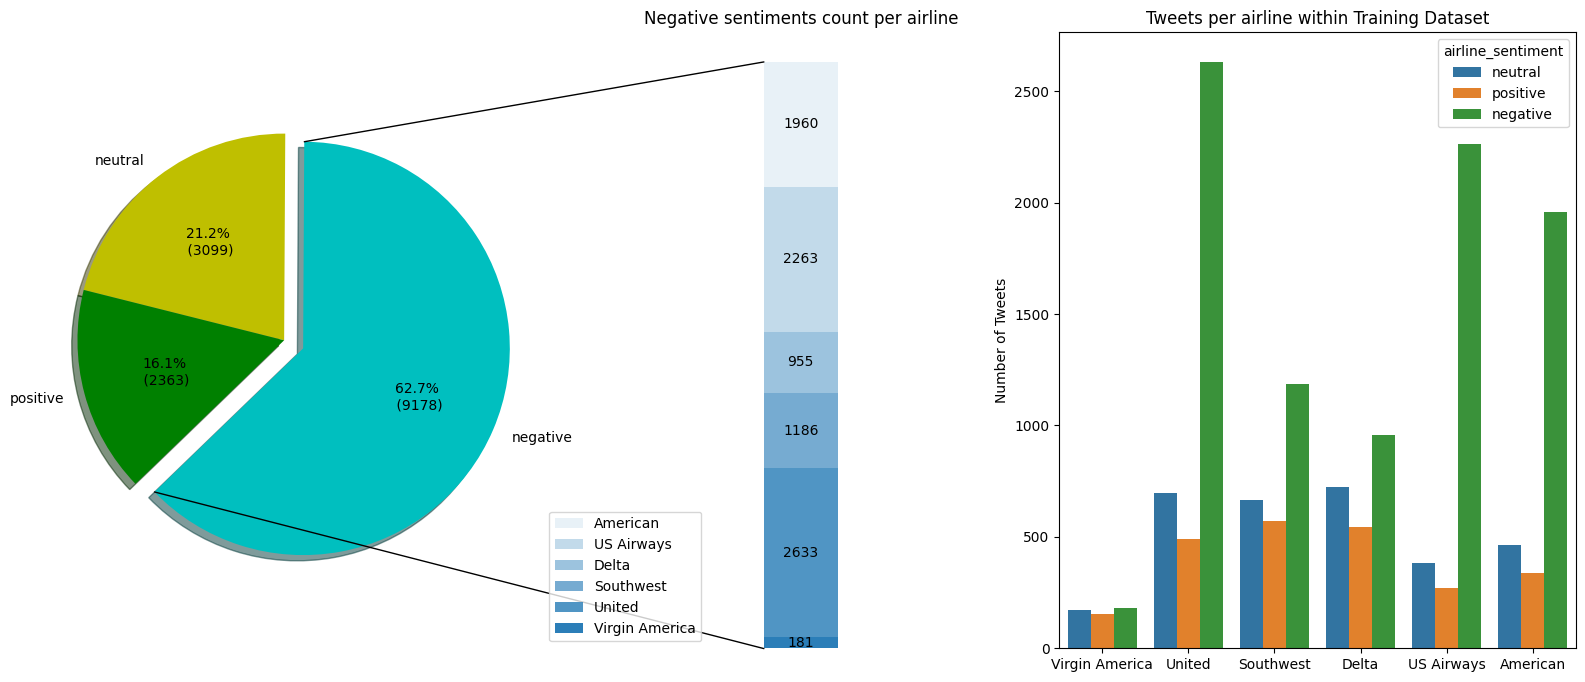

In [29]:
# make figure and assign axis objects
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 8))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = tweet_freq
labels = target_classes
explode = [0.1, 0, 0]
colors =['c','y','g']
# rotate so that first wedge is split by the x-axis
angle = -272 * overall_ratios[2]
wedges, *_ = ax1.pie(overall_ratios, autopct=lambda pct: func(pct, overall_ratios),shadow=True,labels=labels, explode=explode,colors=colors,startangle=angle)

# bar chart parameters
negative_sentiment_ratios =[airlines_sentiments_groups[x]['negative'] for x in list_of_airlines]
airline_labels = list_of_airlines
bottom = 5
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(negative_sentiment_ratios, airline_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,alpha=0.1 + 0.17 * j)
    ax2.bar_label(bc, labels=[height], label_type='center')

ax2.legend(loc=3)
ax2.set_title('Negative sentiments count per airline')
ax2.axis('off')
ax2.set_xlim(- 3.5 * width, 3.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(negative_sentiment_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, -bar_height), coordsA=ax2.transData,xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

ax3 = sns.countplot(x="airline", hue="airline_sentiment", data=dataset)
ax3.set_xlabel('')
ax3.set_ylabel('Number of Tweets')
ax3.set_title('Tweets per airline within Training Dataset')


plt.show()
del ax1,ax2,ax3

##### Date decomposition (feature creation).

In [30]:
def decode_date(date_str)-> pd.Series:
  aux = date_str.replace(' -0800','')
  date_utc = datetime.strptime(aux,"%Y-%m-%d %H:%M:%S")
  return pd.Series([date_utc.weekday(),date_utc.day,date_utc.hour])

In [31]:
dataset[['week_day','day','hour']] = dataset['tweet_created'].apply(decode_date)

In [32]:
dataset.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,week_day,day,hour
0,570306133677760513,neutral,1.0000,N/A,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1,24,11
1,570301130888122368,positive,0.3486,N/A,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1,24,11
2,570301083672813571,neutral,0.6837,N/A,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1,24,11


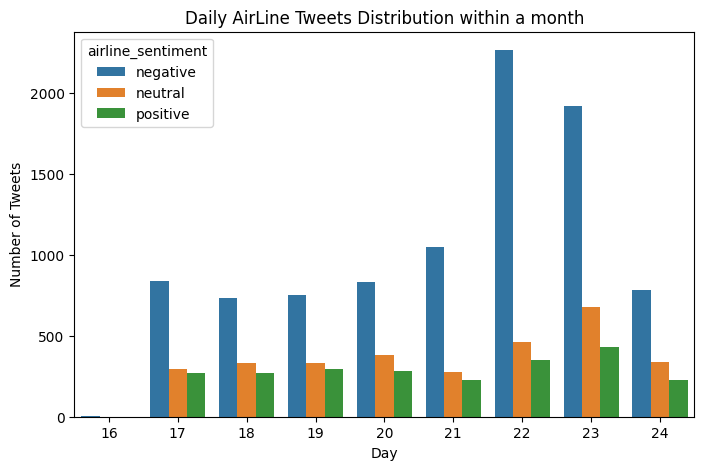

In [33]:
fig, axes = plt.subplots(figsize=(8,5))
ax = sns.countplot(x="day", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Day')
ax.set_ylabel('Number of Tweets')
ax.set_title('Daily AirLine Tweets Distribution within a month')
del ax,fig,axes

<ipython-input-34-48ff6b46cbdf>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


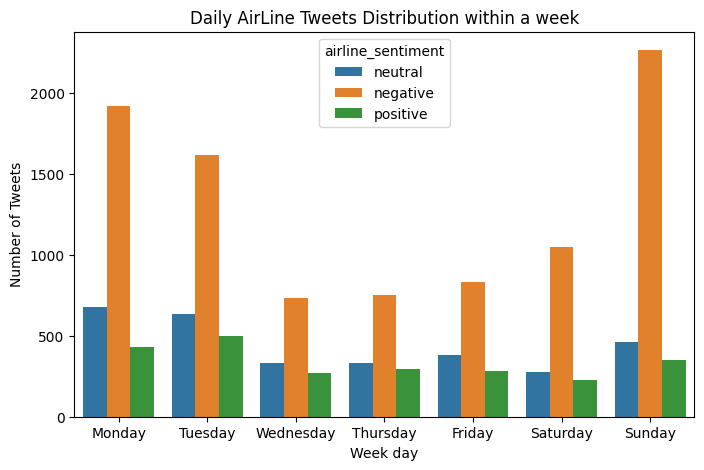

In [34]:
fig, axes = plt.subplots(figsize=(8,5))
ax = sns.countplot(x="week_day", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Week day')
ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_ylabel('Number of Tweets')
ax.set_title('Daily AirLine Tweets Distribution within a week')
del ax,fig,axes

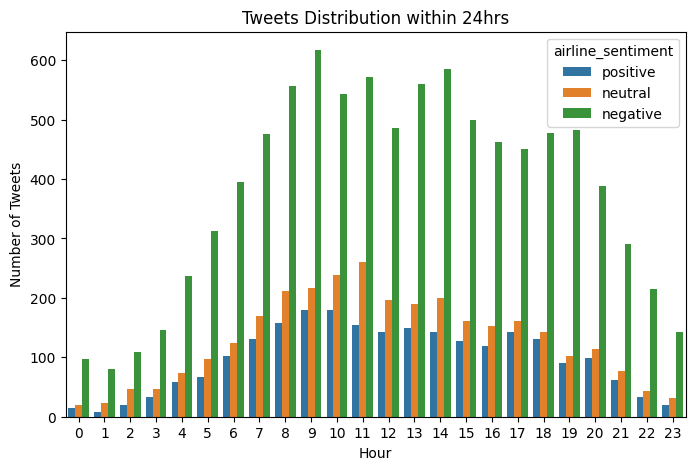

In [35]:
fig, axes = plt.subplots(figsize=(8,5))
ax = sns.countplot(x="hour", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets Distribution within 24hrs')
del ax,fig,axes

### Top 20 tweet authors

In [36]:
top_tweeter = Counter([name for name in dataset['name']])
top_tweeter_df = pd.DataFrame(top_tweeter.most_common(20))
top_tweeter_df.columns = ['top_tweet_authors','count']
print("Top 20 Authors",'-'*15)
top_tweeter_df.style.background_gradient(cmap='inferno')

Top 20 Authors ---------------


,top_tweet_authors,count
0,JetBlueNews,63
1,kbosspotter,32
2,_mhertz,29
3,otisday,28
4,throthra,27
5,rossj987,23
6,weezerandburnie,23
7,MeeestarCoke,22
8,GREATNESSEOA,22
9,scoobydoo9749,21


### Top reasons for complain.

In [37]:
top_complain = Counter([reason for reason in dataset[dataset['negativereason'] != 'N/A']['negativereason']])
top_complain_df = pd.DataFrame(top_complain.most_common(10))
top_complain_df.columns = ['top_complain_reason','count']
print("Top 10 complain",'-'*15)
top_complain_df.style.background_gradient(cmap='inferno')

Top 10 complain ---------------


,top_complain_reason,count
0,Customer Service Issue,2910
1,Late Flight,1665
2,Can't Tell,1190
3,Cancelled Flight,847
4,Lost Luggage,724
5,Bad Flight,580
6,Flight Booking Problems,529
7,Flight Attendant Complaints,481
8,longlines,178
9,Damaged Luggage,74


### Data preprocessing, feature engineering.

In [38]:
#For removing user tags(@user)
def remove_user_tags(tweet:str)->tuple[str,int]:
    user = re.compile(r'@\S+')
    initial = len(tweet)
    text = user.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number+=1
    if( final == initial - number):
      return (result,0)
    else:
      return (result,1)

#For removing Url links
def remove_url(tweet:str)->tuple[str,int]:
    url = re.compile(r'https?://\S+|www\.\S+')
    initial = len(tweet)
    text = url.sub(r'',tweet,re.IGNORECASE)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final == initial - number):
      return (result,0)
    else:
      return (result,1)

In [39]:
def clean_and_create_feature(tweet:str)-> pd.Series:
    (str_without_tags,tag_flag) = remove_user_tags(tweet)
    (str_without_links,url_flag) = remove_url(str_without_tags)
    return pd.Series([str_without_links,tag_flag,url_flag])

In [40]:
dataset[['text','user_tag','url_flag']] = dataset.apply(lambda x: clean_and_create_feature(x.text),axis=1)

In [41]:
dataset.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,week_day,day,hour,user_tag,url_flag
0,570306133677760513,neutral,1.0000,N/A,NaN,Virgin America,NaN,cairdin,NaN,0,What said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1,24,11,1,0
1,570301130888122368,positive,0.3486,N/A,0.0,Virgin America,NaN,jnardino,NaN,0,plus you've added commercials to the experien...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1,24,11,1,0
2,570301083672813571,neutral,0.6837,N/A,NaN,Virgin America,NaN,yvonnalynn,NaN,0,I didn't today... Must mean I need to take an...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1,24,11,1,0


In [42]:
print(dataset.groupby("airline_sentiment", group_keys=True)[['user_tag']].value_counts())
print('-'*50)
print(dataset.groupby("airline_sentiment", group_keys=True)[['url_flag']].value_counts())

airline_sentiment  user_tag
negative           1           9178
neutral            1           3099
positive           1           2363
Name: count, dtype: int64
--------------------------------------------------
airline_sentiment  url_flag
negative           0           8730
                   1            448
neutral            0           2603
                   1            496
positive           0           2134
                   1            229
Name: count, dtype: int64


<ipython-input-43-a6466f72d960>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['With mension tag'])


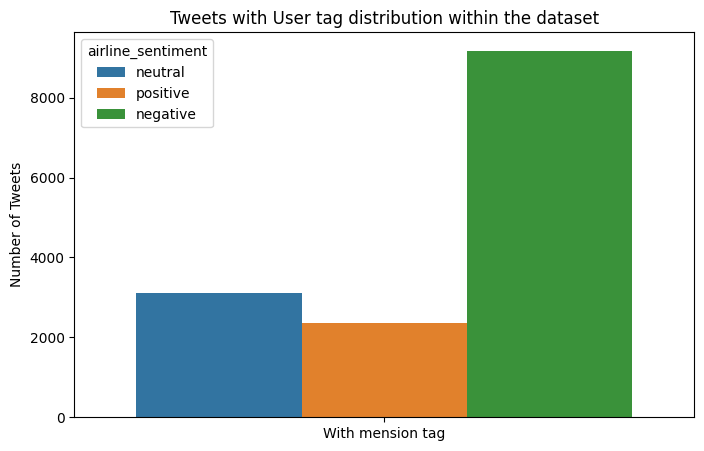

In [43]:
f, axes = plt.subplots(figsize=(8,5))
ax = sns.countplot(x="user_tag", hue="airline_sentiment", data=dataset)
ax.set(xticklabels=['With mension tag'])
ax.set_xlabel('')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets with User tag distribution within the dataset')
del ax,f,axes

<ipython-input-44-e7227f854047>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['Without URL','With URL'])


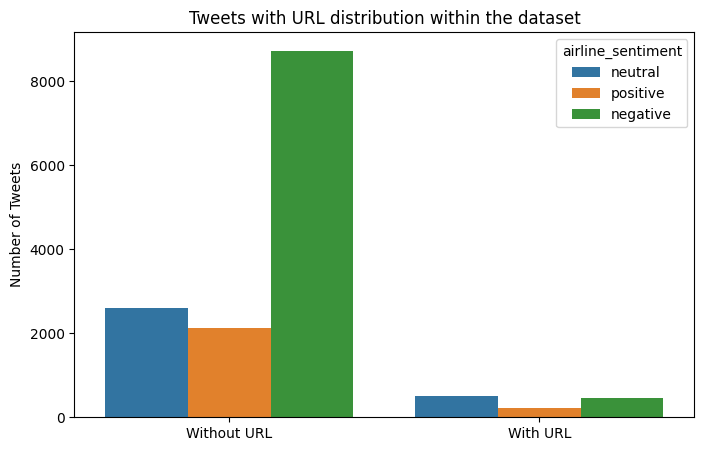

In [44]:
f, axes = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="url_flag",hue="airline_sentiment", data=dataset)
ax.set(xticklabels=['Without URL','With URL'])
ax.set_xlabel('')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets with URL distribution within the dataset')
del ax,f,axes

In [45]:
def happy_emoticons_removal(tweet:str) ->tuple[str,int]:
    happy = re.compile(r"([xX;:]-?[dDpP)])")
    initial = len(tweet)
    text = happy.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

def sad_emoticons_removal(tweet:str) ->tuple[str,int]:
    sad = re.compile(r"[:;](['\"]?[-~]?[/(\|C<>{}\[]+)")
    initial = len(tweet)
    text = sad.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)


In [46]:
def emoticon_removal_and_feature_creation(tweet:str)-> pd.Series:
  (str_without_happy_emoji,happy_emoji_flag) = happy_emoticons_removal(tweet)
  (str_without_emoji,sad_emoji_flag) = sad_emoticons_removal(str_without_happy_emoji)
  return pd.Series([str_without_emoji,happy_emoji_flag,sad_emoji_flag])

In [47]:
dataset[['text','happy_emoji','sad_emoji']] = dataset.apply(lambda x: emoticon_removal_and_feature_creation(x.text),axis=1)

<ipython-input-48-ffbdc1fa1843>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['False','True'])
<ipython-input-48-ffbdc1fa1843>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['True'])


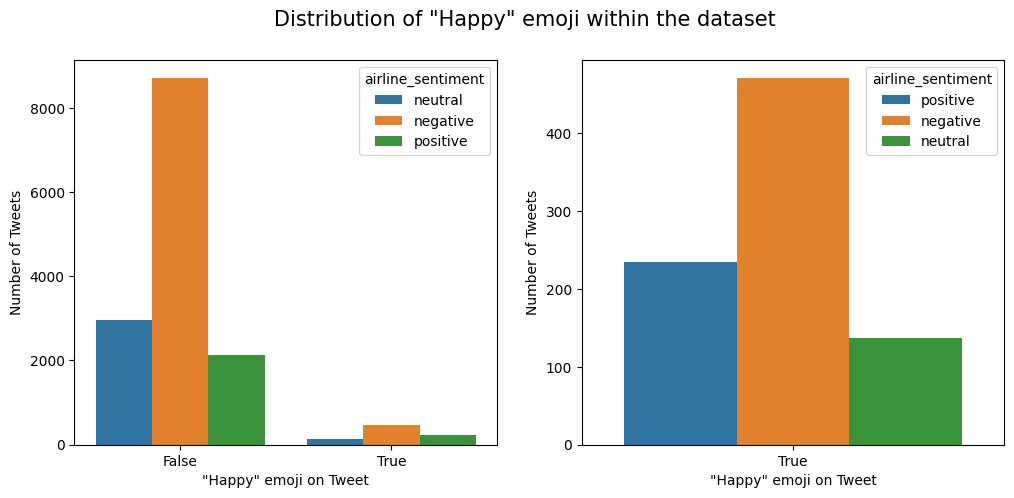

In [48]:
f, axes = plt.subplots(1,2,figsize=(12, 5))
ax = sns.countplot(x="happy_emoji", hue="airline_sentiment", data=dataset,ax=axes[0])
ax.set(xticklabels=['False','True'])
ax.set_xlabel('"Happy" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
ax = sns.countplot(x="happy_emoji", hue="airline_sentiment", data=dataset[dataset.happy_emoji==1],ax=axes[1])
ax.set(xticklabels=['True'])
ax.set_xlabel('"Happy" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
f.suptitle('Distribution of "Happy" emoji within the dataset',fontsize=15)
del ax,f,axes

<ipython-input-49-7a8ad351270a>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['False','True'])
<ipython-input-49-7a8ad351270a>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['True'])


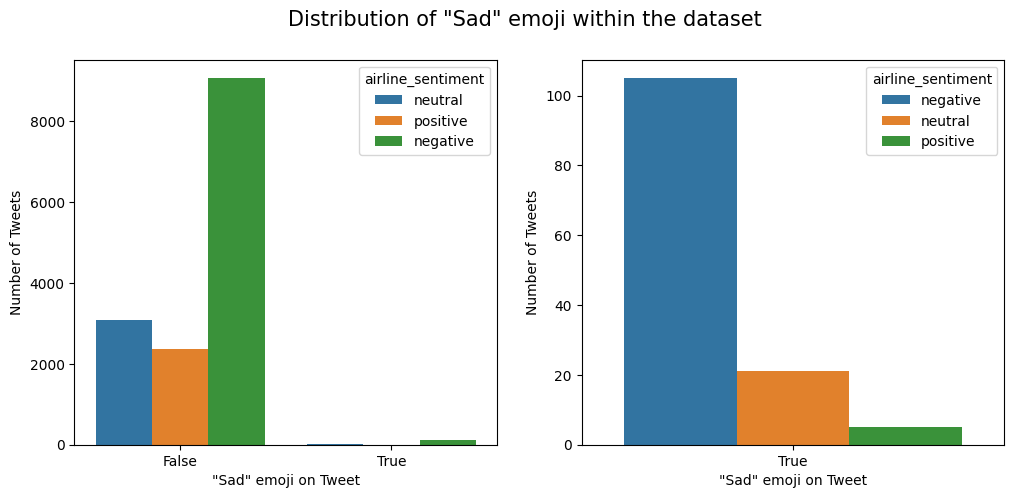

In [49]:
f, axes = plt.subplots(1,2,figsize=(12, 5))
ax = sns.countplot(x="sad_emoji", hue="airline_sentiment", data=dataset,ax=axes[0])
ax.set(xticklabels=['False','True'])
ax.set_xlabel('"Sad" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
ax = sns.countplot(x="sad_emoji", hue="airline_sentiment", data=dataset[dataset.sad_emoji==1],ax=axes[1])
ax.set(xticklabels=['True'])
ax.set_xlabel('"Sad" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
f.suptitle('Distribution of "Sad" emoji within the dataset',fontsize=15)
del ax,f,axes

In [50]:
print(dataset.groupby("airline_sentiment", group_keys=True)[['happy_emoji']].value_counts())
print('-'*50)
print(dataset.groupby("airline_sentiment", group_keys=True)[['sad_emoji']].value_counts())

airline_sentiment  happy_emoji
negative           0              8707
                   1               471
neutral            0              2962
                   1               137
positive           0              2128
                   1               235
Name: count, dtype: int64
--------------------------------------------------
airline_sentiment  sad_emoji
negative           0            9073
                   1             105
neutral            0            3078
                   1              21
positive           0            2358
                   1               5
Name: count, dtype: int64


In [51]:
positive_sentiment = dataset[dataset.airline_sentiment == "positive"]
positive_text=positive_sentiment['text']
negative_sentiment = dataset[dataset.airline_sentiment == 'negative']
negative_text=negative_sentiment['text']
neutral_sentiment = dataset[dataset.airline_sentiment == 'neutral']
neutral_text=neutral_sentiment['text']
complain_text = top_complain_df['top_complain_reason']
top_authors = top_tweeter_df["top_tweet_authors"]

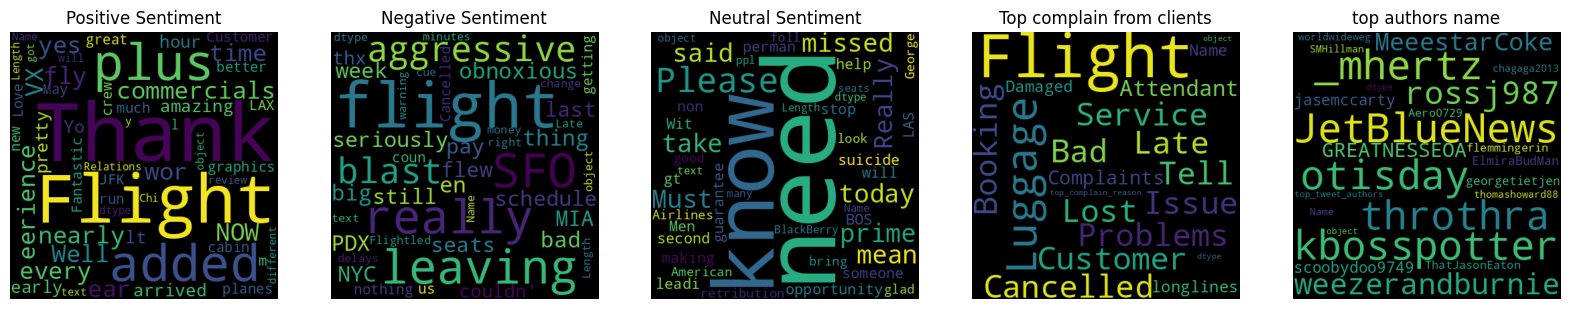

CPU times: user 1.89 s, sys: 264 ms, total: 2.15 s
Wall time: 2.09 s


In [52]:
%%time
# Create and generate a word
fig, ax = plt.subplots(1, 5, figsize=(20, 8),edgecolor = 'k')
positive_tweet = WordCloud(width = 400,height = 400,background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(positive_text))
negative_tweet = WordCloud(width = 400,height = 400,background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(negative_text))
neutral_tweet = WordCloud(width = 400,height = 400,background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(neutral_text))
complain_tweet = WordCloud(width = 400,height = 400,background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(complain_text))
top_authors_tweet = WordCloud(width = 400,height = 400,background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(top_authors))

ax[0].imshow(positive_tweet)
ax[0].axis('off')
ax[0].set_title('Positive Sentiment')

ax[1].imshow(negative_tweet)
ax[1].axis('off')
ax[1].set_title('Negative Sentiment')

ax[2].imshow(neutral_tweet)
ax[2].axis('off')
ax[2].set_title('Neutral Sentiment')



ax[3].imshow(complain_tweet)
ax[3].axis('off')
ax[3].set_title('Top complain from clients')


ax[4].imshow(top_authors_tweet)
ax[4].axis('off')
ax[4].set_title('top authors name')

plt.show()

#### Drop less beneficial columns

In [53]:
dataset.drop(['user_tag','tweet_id','negativereason','tweet_created','negativereason_confidence','airline_sentiment_gold','negativereason_gold','tweet_coord','tweet_location','user_timezone'],axis=1,inplace=True)

In [54]:
print("Sum of missing values",sum(dataset.isnull().sum()))

Sum of missing values 0


In [55]:
target_dict = {'positive':1,'negative': -1,'neutral': 0}
dataset['target'] = dataset['airline_sentiment'].map(target_dict)

In [56]:
def split_dataset(df:pd.DataFrame,test_percentage:float)-> tuple[pd.DataFrame,pd.DataFrame]:
  shuffle = np.random.permutation(len(df))
  test_size = int(len(df) * test_percentage)
  test_aux = shuffle[:test_size]
  train_aux = shuffle[test_size:]
  return (df.iloc[train_aux],df.iloc[test_aux])

In [57]:
train, test = split_dataset(dataset,0.2)

In [58]:
print(train.shape,test.shape)

(11712, 13) (2928, 13)


In [59]:
train.head(3)

,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,week_day,day,hour,url_flag,happy_emoji,sad_emoji,target
4219,negative,1.0000,United,thodge77,0,flight have already been Cancelled Flightled...,1,17,11,0,0,0,-1
13090,negative,0.6326,American,remixrio,0,really appreciate the great customer service....,0,23,11,0,0,0,-1
9033,negative,1.0000,US Airways,pinkgolftees,0,She spoke with someone this AM and was told t...,1,24,9,0,0,0,-1


In [60]:
def stop_word_and_stemming(tweet:str)->str:
    tknzr = TweetTokenizer(preserve_case=False,strip_handles=True, reduce_len=True)
    myStemmer = PorterStemmer()
    tweet = tknzr.tokenize(tweet)
    stop = stopwords.words('english')
    new_list = [myStemmer.stem(word) for word in tweet if word not in stop]
    tweet = ' '.join(new_list)
    return tweet

#For removing punctuation
def remove_punctuations(text:str):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [61]:
train['text'] = train['text'].apply(stop_word_and_stemming)
test['text'] = test['text'].apply(stop_word_and_stemming)

In [62]:
train['text'] = train['text'].apply(remove_punctuations)
test['text'] = test['text'].apply(remove_punctuations)

In [63]:
train.duplicated().any()

True

In [64]:
train.shape

(11712, 13)

In [65]:
train.drop_duplicates(inplace=True)

In [66]:
train.head(3)

,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,week_day,day,hour,url_flag,happy_emoji,sad_emoji,target
4219,negative,1.0000,United,thodge77,0,flight alreadi cancel flightl tri get home tw...,1,17,11,0,0,0,-1
13090,negative,0.6326,American,remixrio,0,realli appreci great custom servic one servic...,0,23,11,0,0,0,-1
9033,negative,1.0000,US Airways,pinkgolftees,0,spoke someon told breast pump medic equip pla...,1,24,9,0,0,0,-1


### Baseline Model Implementation


In [67]:
y = train['target'].to_numpy()

In [68]:
y_t = test['target'].to_numpy()

In [69]:
vec = CountVectorizer(max_df=0.95,min_df=2).fit(train['text'])

In [70]:
X = vec.transform(train['text'])

In [71]:
X_t =vec.transform(test['text'])

In [72]:
vocab_size = len(vec.vocabulary_) + 1

In [73]:
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 3873


In [74]:
# feature selection
def features_selection(X_train, y_train, X_test):
	SKB = SelectKBest(score_func=chi2, k='all')
	SKB.fit(X_train, y_train)
	X_train_fs = SKB.transform(X_train)
	X_test_fs = SKB.transform(X_test)
	return X_train_fs, X_test_fs, SKB

In [75]:
X_train_fs, X_test_fs, SKB = features_selection(X, y, X_t)

In [76]:
for i in range(3):
	print('Feature %d: %f' % (i, SKB.scores_[i]))

Feature 0: 6.939616
Feature 1: 4.683408
Feature 2: 1.212121


In [101]:
param_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0]}
clf = LinearSVC(loss='hinge',random_state=1,class_weight="balanced")

In [102]:
grids = GridSearchCV(clf, param_grid,verbose=1,n_jobs=-1)
grids = grids.fit(X_train_fs, y)
print ("Best parameters: %s" % grids.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 0.1}


In [103]:
predictions = grids.predict(X_test_fs)

In [104]:
print("Achieved baseline accuracy: %0.3f" % accuracy_score(y_t, predictions))

Achieved baseline accuracy: 0.774


In [106]:
print(test.text[y_t!=predictions])

865            ticket  pleas refund unnecessari upgrad fee
10903    sit ground charlott gate comm flight deck grea...
13140    hold nd time today  need help confirm new flig...
1936     let  real nice  love awesom servic  u peopl wo...
12327    thank recommend  wev sit minut  last updat min...
                               ...                        
12427    motor usual start engin broke ground crew fail...
4968      got back min ago  went hr w  appreci support ...
14516                               cut  put flt tomorrow 
7810            stand cell announc info thismosaicnothappi
3422     guess that busiest rout  base traffic  fuel co...
Name: text, Length: 662, dtype: object
